In [90]:
from __future__ import division, print_function
%matplotlib inline
from ipywidgets import interact, IntSlider
import book_format
book_format.set_style()
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from kf_book.book_plots import set_figsize,figsize
pylab.rcParams['figure.max_open_warning'] = 50
%precision 4


/Users/fafa/py37/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


'%.4f'

# Data Filtering Tequniques

Examples and build function are inspired from [Kalman-and-Bayesian-Filters-in-Python](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python) a jupyter book that provides the basics for Bayesian and Kalman Filtering. For further datails on the presented tequniques please refer to the link.

## Building Intuition through Thought Experiments


Imagine that we live in a world without scales - the devices you stand on to weigh yourself. One day a friend of yours comes running up to you and announces her invention of a 'scale' to you. After she explains, you eagerly stand on it and announce the results: "90 kg".

Another friend hears the commotion and comes over to find out what has you so excited. You explain the invention and once again step onto the scale, and proudly proclaim the result: "82 kg." And then you hesitate, confused.

"It read 90 kg a few seconds ago", you complain to your friend. 

"I never said it was accurate," she replies.

**Sensors are inaccurate!**

What can we conclude about your weight?

Well, what are our choices?

* We could choose to only believe A, and assign 82kg to our weight estimate.
* We could choose to only believe B, and assign 90kg to our weight.
* We could choose a number less than both A and B.
* We could choose a number greater than both A and B.
* We could choose a number between A and B.


The first two choices are plausible, but why A should be better than B?

The third and fourth choices are irrational. 

The final choice is the only reasonable one. If both scales are inaccurate **the answer is somewhere between A and B.** 

For example, suppose our actual weight is 100 kg. 

82 kg is a big error. 
But if we choose a weight between 82 kg and 90 kg our estimate will be better than 82 kg. 

For now I hope it is clear that our best estimate is the average of A and B. 

$$\frac{82+90}{2} = 86$$

We can look at this graphically. I have plotted the measurements of A and B with an assumed error of $\pm$ 6 kg. The measurements falls between 82 and 90 so the only weight that makes sense must lie within 82 and 90 kg. 

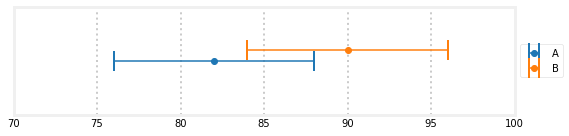

In [2]:
import kf_book.book_plots as book_plots
from kf_book.book_plots import plot_errorbars
plot_errorbars([(82, 6, 'A'), (90, 6, 'B')], xlims=(70, 100))

The only weights that are possible lie in the intersection between the error bars of A and B. 



What if we are now told that A is three times more accurate than B? 

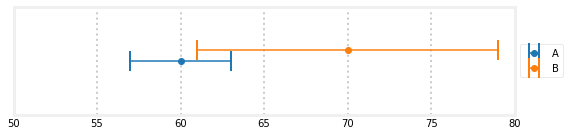

In [3]:
plot_errorbars([(60, 3, 'A'), (70, 9, 'B')], xlims=(50, 80))

The overlap of the error bars of A and B are the only possible true weight. This overlap is smaller than the error in A alone. 



**So two sensors, even if one is less accurate than the other, is better than one.**

What if you measured your weight once a day, and got the readings 70, 71, and then 69. 

Did you gain weight, lose weight, or is this all just noisy measurements?

We really can't say. 

The first measurement was 70, and the last was 69, implying a 1 kg loss. 

But if the scale is only accurate to 10 kg, that is explainable by noise.

It is possible, for example, that you gained 1 kg each day, and the noisy measurements just happens to look like you stayed the same weight?

Equally, you could have lost 1 kg a day and gotten the same readings?

But is that likely? How likely is it to flip a coin and get 10 heads in a row?

Not very likely. 

We can't prove it based solely on these readings, but it seems pretty likely that my weight held steady. 

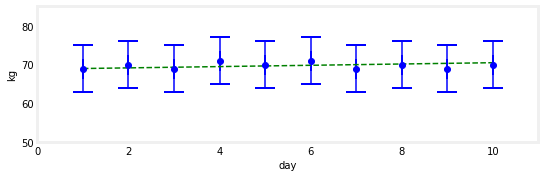

In [4]:
import kf_book.gh_internal as gh
gh.plot_hypothesis2()

Suppose I start weigh my self for 12 days and I get the following measurments: 58.0, 64.2, 60.3, 59.9, 62.1, 64.6, 69.6, 67.4, 66.4, 71.0 . 

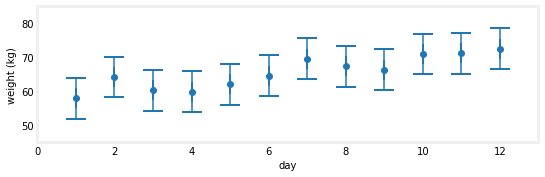

In [5]:
gh.plot_hypothesis3()

Does it 'seem' likely that I lost weight and this is just really noisy data? Not really. 

Does it seem likely that I held the same weight? Again, no. 

This data trends upwards over time; not evenly, but definitely upwards. 

So let's look at two hypotheses. 




First, let's assume our weight did not change. To get that number we agreed that we should average the measurements. Let's look at that.

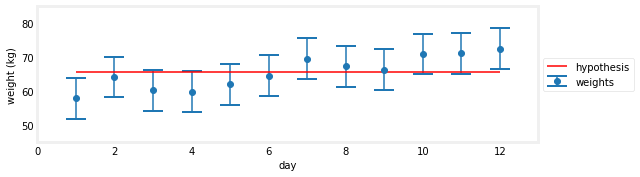

In [6]:
gh.plot_hypothesis4()

That doesn't look very convincing. In fact, we can see that there is no horizontal line that we could draw that is inside all of the error bars.

Now, let's assume we gained weight. 

How much? 

I can perform a regresion with "least squares fit".

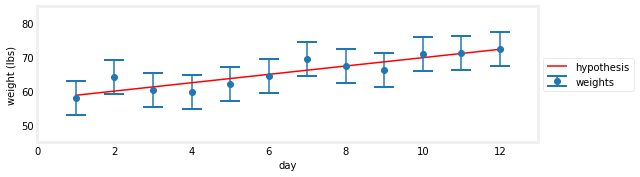

In [7]:
gh.plot_hypothesis5()

This looks much better, at least to my eyes. 

Notice now the hypothesis lies very close to each measurement, whereas in the previous plot the hypothesis was often quite far from the measurement. 

It seems far more likely to be true that I gained weight than I didn't gain any weight. 

Did I actually gain 13 kg? Who can say? That seems impossible to answer.

"But is it impossible?"

Let's assume that I know I am gaining about 1 kg a day beacouse I am on a 6000 calorie a day diet, which would result in such a weight gain.

Let's see if we can make use of such information if it was available.

The first measurement was 58. We have no way of knowing any different, so let's accept that as our estimate. If our weight today is 58, what will it be tomorrow? Well, we think we are gaining weight at 1 kg/day, so our prediction is 59, like so:

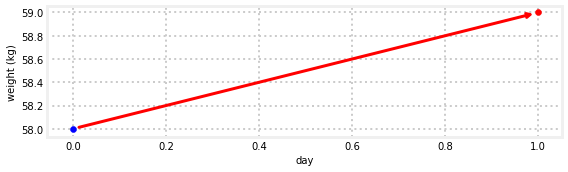

In [8]:
gh.plot_estimate_chart_1()

Okay, but what good is this? Sure, we could assume the 1 kg/day is accurate, and predict our weight for the next 10 days. 

But then the next day we step on the scale again and it displays 64.2 kg.

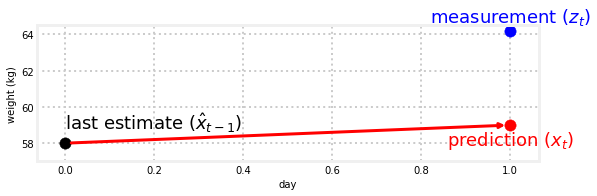

In [9]:
gh.plot_estimate_chart_2()

We have a problem. Our prediction doesn't match our measurement. 



But, that is what we expected, right? 

If the prediction was always exactly the same as the measurement, it would not be capable of adding any information.

And, of course, there would be no reason to ever measure since our predictions are perfect.



So what do we do? 

If we only form estimates from the measurement then the prediction will not affect the result. 

If we only form estimates from the prediction then the measurement will be ignored. 

We need to take some kind of way to **blend the prediction and measurement**.

Blending two values - this sounds a lot like the two scale problem earlier. 


Using the same reasoning as before we can see that the only thing that makes sense is to choose a number between the prediction and the measurement. 

For example, an estimate of 65 makes no sense, nor does 57. Our estimates should lie between 59 (the prediction) and 64.2 (the measurement).

Should the estimate be half way between the measurement and prediction?

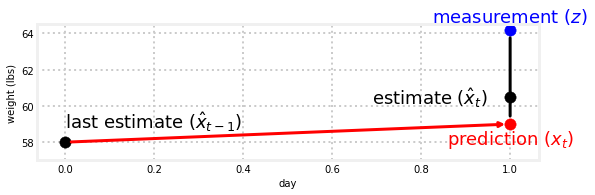

In [10]:
gh.plot_estimate_chart_3()

Now let's try a randomly chosen number to scale our estimate: $\frac{4}{10}$. 

Our estimate will be four tenths the measurement and the rest will be from the prediction. In other words, we are expressing a **belief** here, a belief that the prediction is somewhat more likely to be correct than the measurement. We compute that as

$$\mathtt{estimate} = \mathtt{prediction} + \frac{4}{10}(\mathtt{measurement} - \mathtt{prediction})$$

The difference between the measurement and prediction is called the **residual**. 

This will become an important value to use later on, as it is an exact computation of the difference between measurements and the filter's output.

**Smaller residuals imply better performance.**

In [11]:


def predict_using_gain_guess(estimated_weight, gain_rate, do_print=False):     
    # storage for the filtered results
    estimates, predictions = [estimated_weight], []

    # most filter literature uses 'z' for measurements
    for z in weights: 
        # predict new position
        predicted_weight = estimated_weight + gain_rate * time_step

        # update filter 
        estimated_weight = predicted_weight + scale_factor * (z - predicted_weight)

        # save and log
        estimates.append(estimated_weight)
        predictions.append(predicted_weight)
        if do_print:
            gh.print_results(estimates, predicted_weight, estimated_weight)

    return estimates, predictions

weights = [58.0, 64.2, 60.3, 59.9, 62.1, 64.6, 
           69.6, 67.4, 66.4, 71.0, 71.2, 72.6]

time_step = 1.0  # day
scale_factor = 4.0/10

initial_estimate = 60.

previous estimate: 60.00, prediction: 61.00, estimate 59.80
previous estimate: 59.80, prediction: 60.80, estimate 62.16
previous estimate: 62.16, prediction: 63.16, estimate 62.02
previous estimate: 62.02, prediction: 63.02, estimate 61.77
previous estimate: 61.77, prediction: 62.77, estimate 62.50
previous estimate: 62.50, prediction: 63.50, estimate 63.94
previous estimate: 63.94, prediction: 64.94, estimate 66.80
previous estimate: 66.80, prediction: 67.80, estimate 67.64
previous estimate: 67.64, prediction: 68.64, estimate 67.75
previous estimate: 67.75, prediction: 68.75, estimate 69.65
previous estimate: 69.65, prediction: 70.65, estimate 70.87
previous estimate: 70.87, prediction: 71.87, estimate 72.16


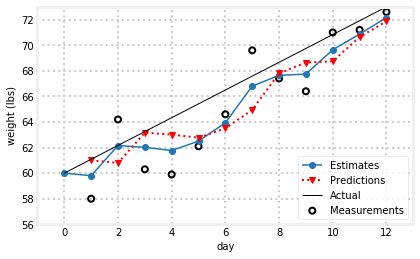

In [12]:
estimates, predictions = predict_using_gain_guess(
    estimated_weight=initial_estimate, gain_rate=1, do_print=True)
# plot results
gh.plot_gh_results(weights, estimates, predictions, [60, 73])

Let's see what the filter does if our initial guess is bad. Let's predict that there is a weight loss of 1 kg a day:

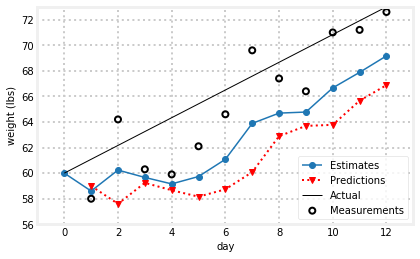

In [13]:
e, p = predict_using_gain_guess(initial_estimate, -1.)
gh.plot_gh_results(weights, e, p, [60, 73])

What if instead of leaving the weight gain at the initial guess, we compute it from the existing measurements and estimates?

On day one our estimate for the weight is:

$$
(60 + 1) + \frac{4}{10}(58-61) = 59.8
$$



On the next day we measure 64.2, which implies a weight gain of 3.4 kg (since 64.2 - 60.8 = 3.4), not 1. 

Can we use this information somehow? 



The weight measurement itself is based on a real world measurement of our weight, so there is useful information. 

Our estimate of our weight gain may not be perfect, but it is surely better than just guessing our gain is 1 kg. **Data is better than a guess, even if it is noisy.** 

Should we set the new gain/day to 3.4 kg? Yesterday we thought the weight gain was 1 kg, today we think it is 3.4 kg. We have two numbers, and want to combine them somehow. 


Hmm, sounds like our same problem again.

Let's use our same tool, and the only tool we have so far - pick a value part way between the two. 

This time I will use another arbitrarily chosen number, $\frac{1}{3}$:

$$\text{new gain} = \text{old gain} + \frac{1}{3}\frac{\text{measurement - predicted weight}}{1 \text{ day}}
$$

The equation is identical as for the weight estimate except we have to incorporate time because this is a rate (gain/day)

In [14]:


estimated_weight = 60.  # initial guess
gain_rate = -1.0  # initial guess

time_step = 1.
scale_factor = 4./10
gain_scale = 1./3
estimates = [estimated_weight]
predictions = []

for z in weights:
    # prediction step
    predicted_weight = estimated_weight + gain_rate*time_step
    predictions.append(predicted_weight)
    
    # update step    
    residual = z - predicted_weight

    estimated_weight = predicted_weight + scale_factor * residual

    gain_rate = gain_rate + gain_scale * (residual/time_step)

    estimates.append(estimated_weight)


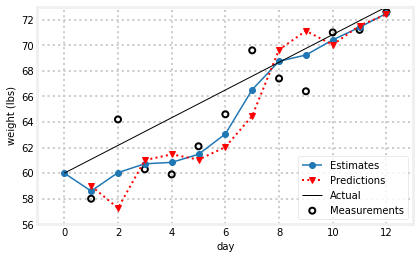

In [15]:
gh.plot_gh_results(weights, estimates, predictions, [60, 73])

## The g-h Filter

This algorithm is known as the [g-h filter](https://en.wikipedia.org/wiki/Alpha_beta_filter) or the $\alpha$-$\beta$ filter. $g$ and $h$ refer to the two scaling factors that we used in our example. $g$ is the scaling we used for the measurement (**scale_factor** in our example), and $h$ is the scaling for the change in measurement over time (**gain_scale** in our example). 

This filter is the basis for a huge number of filters, that differs in the way of assigning values to $g$ and $h$, but otherwise the algorithms are identical. 

**Let me repeat the key points as they are so important**.

* Multiple data points are more accurate than one data point, so throw nothing away no matter how inaccurate it is.
* Always choose a number part way between two data points to create a more accurate estimate.
* Predict the next measurement and rate of change based on the current estimate and how much we think it will change.
* The new estimate is then chosen as part way between the prediction and next measurement scaled by how accurate each is.


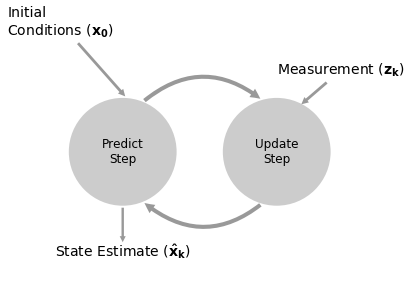

In [16]:
book_plots.predict_update_chart()

The **system** is the object that we want to estimate.  

The __state__ of the system is the current configuration or values of that system that is of interest to us. 

The **measurement** is a measured value of the system. Measurements can be inaccurate, so it may not have the same value as the state.

The **state estimate** is our filter's estimate of the state.

We use a **process model** to mathematically model the system. 

The **system error** or **process error** is the error in this model.  


The **predict step** is known as **system propagation**. It uses the **process model** to form a new **state estimate**. 

Because of the **process error** this estimate is imperfect. Assuming we are tracking data over time, we say we **propagate** the state into the future.

The **update step** is known as the **measurement update**. One iteration of the system propagation and measurement update is known as an **epoch**. 

The fundamental idea is to **blend** somewhat **inaccurate measurements** with somewhat **inaccurate models** of how the systems behaves to get a **filtered estimate** that is **better** than either information source by itself.

We can express this as an algorithm:

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state

**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. New estimate is somewhere on the residual line

## Generic Algorithm

In [17]:
from kf_book.gh_internal import plot_g_h_results
import matplotlib.pylab as pylab
import numpy as np

def g_h_filter(data, x0, dx, g, h, dt=1.):
    """
    Performs g-h filter on 1 state variable with a fixed g and h.

    'data' contains the data to be filtered.
    'x0' is the initial value for our state variable
    'dx' is the initial change rate for our state variable
    'g' is the g-h's g scale factor
    'h' is the g-h's h scale factor
    'dt' is the length of the time step 
    """
    x_est = x0
    results = []
    for z in data:
        # prediction step
        x_pred = x_est + (dx*dt)
        dx = dx

        # update step
        residual = z - x_pred
        dx = dx + h * (residual) / dt
        x_est = x_pred + g * residual
        results.append(x_est)
    return np.array(results)


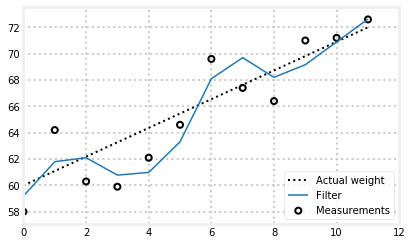

In [18]:

book_plots.plot_track([0, 11], [60, 72], label='Actual weight')
data = g_h_filter(data=weights, x0=60., dx=1., g=6./10, h=2./3, dt=1.)
plot_g_h_results(weights, data)

## Choice of $g$ and $h$

The g-h filter is not one filter - it is a classification for a family of filters. Eli Brookner in *Tracking and Kalman Filtering Made Easy* lists 11, and I am sure there are more. Each filter is differentiated by how $g$ and $h$ are chosen. **So there is no 'one size fits all'**. Some filters set $g$ and $h$ as constants, others vary them dynamically. The Kalman filter varies them dynamically at each step. Some filters allow $g$ and $h$ to take any value within a range, others constrain one to be dependent on the other by some function $f(\dot{}), \mbox{where }g = f(h)$.


It is worth seeing how varying $g$ and $h$ affects the results, so we will work through some examples.

## Measurement function

Now let's write a function that generates noisy data for us. 

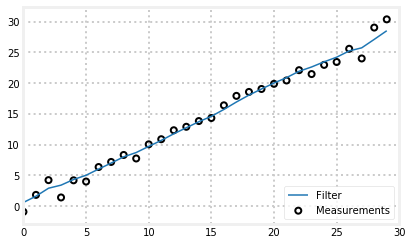

In [19]:
from numpy.random import randn

def gen_data(x0, dx, count, noise_factor):
    return [x0 + dx*i + randn()*noise_factor for i in range(count)]

measurements = gen_data(0, 1, 30, 1)
data = g_h_filter(data=measurements, x0=0., dx=1., dt=1., g=.2, h=0.02)
plot_g_h_results(measurements, data)

## Bad Initial Conditions

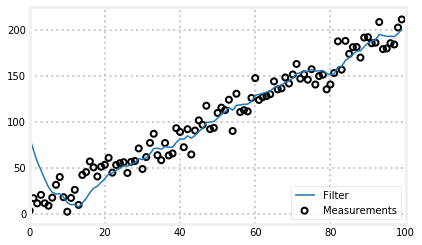

In [20]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=10)
data = g_h_filter(data=zs, x0=100., dx=2., dt=1., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

## Extreme Noise

Now we rerun the same test, but this time use a noise factor of 50. 

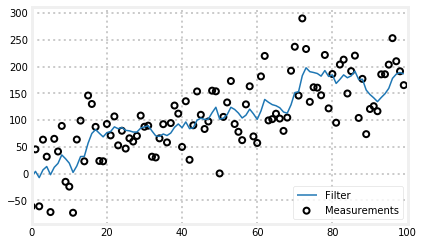

In [21]:
zs = gen_data(x0=5., dx=2., count=100, noise_factor=50)
data = g_h_filter(data=zs, x0=5., dx=2., g=0.2, h=0.02)
plot_g_h_results(measurements=zs, filtered_data=data)

We can see that the filtered signal varies less than the noisy signal, but it is far from the straight line. 

Can we improve it?

## Varying $g$

Now let's look at the effect of varying $g$. Before you perform this exercise, recall that $g$ is the scale factor for choosing between the measurement and prediction. What do you think the effect of a large value of $g$ will be? A small value?

Now, let the `noise_factor=50` and `dx=5`. Plot the results of $g = 0.1\mbox{, } 0.4,\mbox{ and } 0.8$.

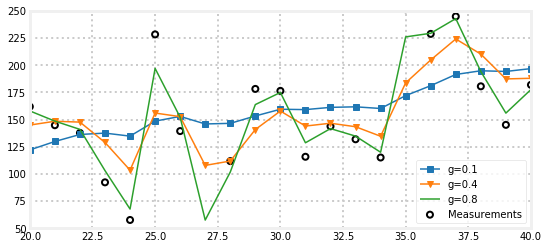

In [22]:
zs = gen_data(x0=5., dx=5., count=50, noise_factor=50)
data1 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.4, h=0.01)
data3 = g_h_filter(data=zs, x0=0., dx=5., dt=1., g=0.8, h=0.01)

with book_plots.figsize(y=4):
    book_plots.plot_measurements(zs, color='k')
    book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
    book_plots.plot_filter(data2, label='g=0.4', marker='v', c='C1')
    book_plots.plot_filter(data3, label='g=0.8', c='C2')
    plt.legend(loc=4)
    book_plots.set_limits([20, 40], [50, 250])

It is clear that as $g$ is **larger** we more closely **follow the measurement** instead of the **prediction**. 
When $g=0.8$ we follow the signal almost exactly, and reject almost none of the noise. One might naively conclude that $g$ should always be very small to maximize noise rejection. However, that means that we are mostly ignoring the measurements in favor of our prediction. What happens when the signal changes not due to noise, but an actual state change? Let's have a look. I will create data that has $\dot{x}=1$ for 9 steps before changing to $\dot{x}=0$. 

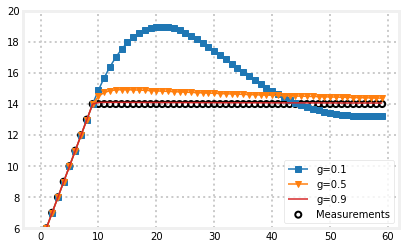

In [23]:
zs = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
for i in range(50):
    zs.append(14)

data1 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.1, h=0.01)
data2 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.5, h=0.01)
data3 = g_h_filter(data=zs, x0=4., dx=1., dt=1., g=0.9, h=0.01)

book_plots.plot_measurements(zs)
book_plots.plot_filter(data1, label='g=0.1', marker='s', c='C0')
book_plots.plot_filter(data2, label='g=0.5', marker='v', c='C1')
book_plots.plot_filter(data3, label='g=0.9', c='C3')
plt.legend(loc=4)
plt.ylim([6, 20]);

## Varying $h$

We know that $h$ affects **how much we trust the measurement** of $\dot{x}$ vs our prediction. 

But what does this *mean*? 

If our signal is changing a lot (quickly relative to the time step of our filter), then a large $h$ will cause us to react to those **transient changes rapidly**. 

A smaller $h$ will cause us to react **more slowly**.

## Interactive Example


In [24]:
from ipywidgets import interact

# my FloatSlider returns an ipywidgets.FloatSlider with
# continuous_update=False. Filtering code runs too slowly
# to instantly react to slider changes.
from kf_book.book_plots import FloatSlider

zs1 = gen_data(x0=5, dx=5., count=100, noise_factor=50)

fig = None
def interactive_gh(x, dx, g, h):
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure()
    data = g_h_filter(data=zs1, x0=x, dx=dx, g=g, h=h)
    plt.scatter(range(len(zs1)), zs1, edgecolor='k', 
                facecolors='none', marker='o', lw=1)
    plt.plot(data, color='b')

interact(interactive_gh,           
         x=FloatSlider(value=0, min=-200, max=200), 
         dx=FloatSlider(value=5, min=-50, max=50), 
         g=FloatSlider(value=.1, min=.01, max=2, step=.02), 
         h=FloatSlider(value=.02, min=.0, max=.5, step=.01));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='x', max=200.0, min=-200.0),…

# Discrete Bayes Filter

Immagine that we want to track the pidgion in the corridor of politecnico, so we attach a device to him that sense if he is infront of a door and the direction of movement. 

If we start listening to the sensor we might read **door**, **hall**, **hall**, and so on. 

How can we use that information to determine where the pidgion is?

To keep the problem small enough to plot easily we will assume that there are only 10 positions in the hallway, which we will number 0 to 9, where 1 is to the right of 0.

When we begin listening to the sensor we have no reason to believe that the pidgion is at any particular position in the corridor. 

There are 10 positions, so the probability that he is in any given position is 1/10. 

In [25]:
import numpy as np
belief = np.array([1./10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In Bayesian statistics this is called a **prior probability distribution**, it lists all possible events and the probability of each 

A probability distribution is a collection of **all possible probabilities for an event**. 

Probability distributions **always sum to 1** because something had to happen.

Now let's create a map of the corridot. We'll place the first two doors close together, and then another door further away. We will use 1 for doors, and 0 for walls:

In [26]:
corridor = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

So we start listening to pidgion's sensor and the first data we get from the sensor is **door**. 

Assuming a sensor tha always returns the correct answer we can conclude that he is in front of a door, but which one? 

We have no reason to believe he is in front of the first, second, or third door. 


What we can do is assign a probability to each door. All doors are equally likely so we assign a probability of 1/3 to each door.

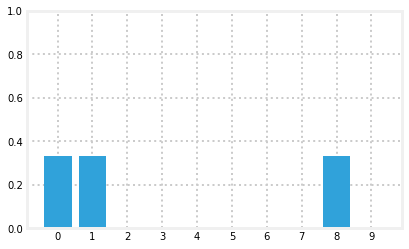

In [27]:
belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1/3, 0])
book_plots.bar_plot(belief)

This distribution is called a [*categorical distribution*](https://en.wikipedia.org/wiki/Categorical_distribution), which is a discrete distribution describing the probability of observing $n$ outcomes. 

It is a [*multimodal distribution*](https://en.wikipedia.org/wiki/Multimodal_distribution) because we have multiple beliefs about the position of our dog.

In [28]:
belief = corridor * (1./3)
print(belief)

[0.3333 0.3333 0.     0.     0.     0.     0.     0.     0.3333
 0.    ]


Perfect sensors are rare. Perhaps the sensor would not detect a door if the pidgion sat in front of it while scratching himself, or misread if he is not facing down the hallway.

```Python
belief=[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01]
```

If the sensor is noisy it casts doubt on every piece of data. 

How can we conclude anything if we are always unsure?


We have already assigned a probabilistic belief to the location of the pidgion! 

Now we have to incorporate the additional uncertainty caused by the sensor noise. 

Say we get a reading of **door**, and suppose that the sensor as a probability of correct answer of 75%.
So it means that we have to **scale** our **probablity distribution** (belief) of:

$$scale =  \frac{prob_{correct}}{prob_{incorrect}} = \frac{prob_{correct}} {1-prob_{correct}} = \frac{0.75} {1-0.75} = 3$$



In [29]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(corridor, belief, z=reading, correct_scale=3.)

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


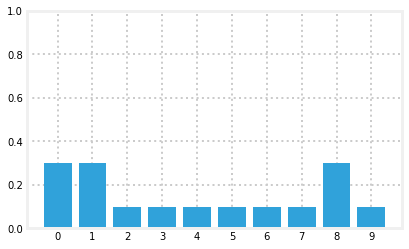

In [30]:
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

In [31]:
belief / sum(belief)

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.1875, 0.0625])

In [32]:
from filterpy.discrete_bayes import normalize

def scaled_update(corr, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[corr==z] *= scale
    normalize(belief)

belief = np.array([0.1] * 10)
scaled_update(corridor, belief, z=1, z_prob=.75)

sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


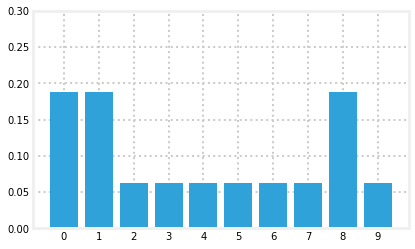

In [33]:

print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

The results of the update is called **posterior** with is the **normalized** product of the **prior** and the **likelihood**.

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$ 

When we talk about the filter's output we typically call the state after performing the prediction the **prior** or **prediction**, and we call the state after the update either the **posterior** or the **estimated state**. 

In [34]:
from filterpy.discrete_bayes import update

def lh_corridor(corr, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(corr))
    likelihood[corr==z] *= scale
    return likelihood

belief = np.array([0.1] * 10)
likelihood = lh_corridor(corridor, z=1, z_prob=.75)
update(likelihood, belief) 

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.1875, 0.0625])

## Adding Measrument with uncertainty


The sensor's senes even the movement.

The measurement is 80% likely to be correct, 10% likely to overshoot one position to the right, and 10% likely to undershoot to the left. 


For example, consider the reported movement of 2. If we are 100% certain the pidgion started from position 3, then there is an 80% chance he is at 5, and a 10% chance for either 4 or 6.

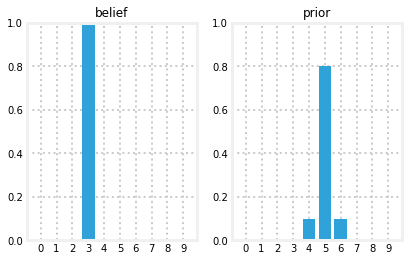

In [35]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)

It appears to work correctly. Now what happens when our belief is not 100% certain?

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

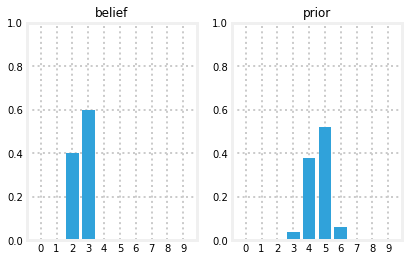

In [36]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

In [37]:
belief = np.array([1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
beliefs = []
    
for i in range(100):
    belief = predict_move(belief, 1, .1, .8, .1)
    beliefs.append(belief)

print('Final Belief:', belief)

# make interactive plot
def show_prior(step):
    book_plots.bar_plot(beliefs[step-1])
    plt.title('Step {}'.format(step))

interact(show_prior, step=IntSlider(value=1, max=len(beliefs)));

Final Belief: [0.1041 0.1033 0.1013 0.0987 0.0967 0.0959 0.0967 0.0987 0.1013
 0.1033]


interactive(children=(IntSlider(value=1, description='step'), Output()), _dom_classes=('widget-interact',))

## Integrating Measurements and Movement Updates


The problem of losing information during a prediction may make it seem as if our system would quickly devolve into having no knowledge. 

However, each prediction is followed by an update where we incorporate the measurement into the estimate. 

The update improves our knowledge.

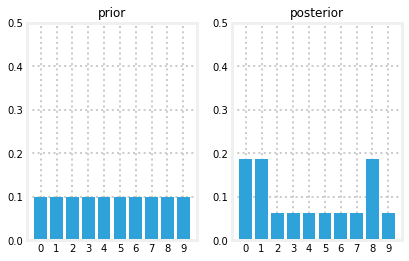

In [38]:
from filterpy.discrete_bayes import update

corridor = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_corridor(corridor, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

After the first update we have assigned a high probability to each door position, and a low probability to each wall position.

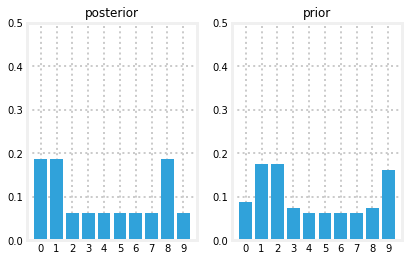

In [39]:
prior = predict_move(posterior, 1, .1, .8, .1)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0,.5))

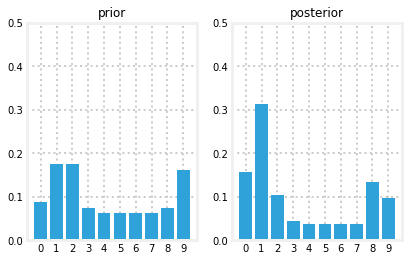

In [40]:
likelihood = lh_corridor(corridor, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

Notice the tall bar at position 1. 

This corresponds with the (correct) case of starting at position 0, sensing a door, shifting 1 to the right, and sensing another door. 

No other positions make this set of observations as likely. 

Now we will add an update and then sense the wall.

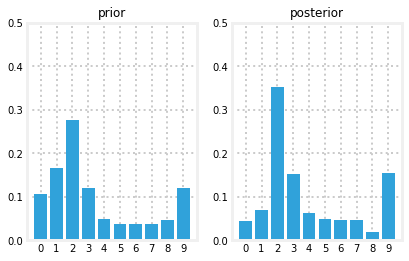

In [41]:
prior = predict_move(posterior, 1, .1, .8, .1)
likelihood = lh_corridor(corridor, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

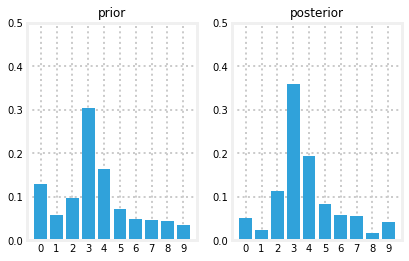

In [42]:
prior = predict_move(posterior, 1, .1, .8, .1)
likelihood = lh_corridor(corridor, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

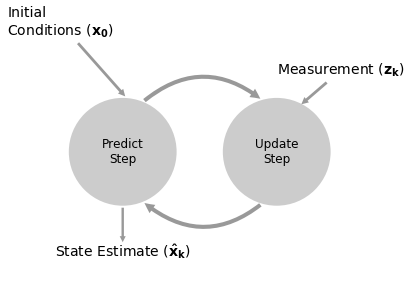

In [43]:
book_plots.predict_update_chart()

**Initialization**

    1. Initialize our belief in the state
    
**Predict**

    1. Based on the system behavior, predict state for the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute how likely it is the measurement matches each state
    3. Update state belief with this likelihood

## Kalman Filters

You can use a Kalman filter in any place where you have **uncertain information** about some **dynamic system**, and you can make an educated guess about what the system is going to do next. 


Kalman filters are **ideal** for systems which are **continuously changing**.


They have the advantage that they are **light on memory** (they don’t need to keep any history other than the previous state), and they are **very fast**, making them well suited for **real time problems and embedded systems**.


As in the **Discrete Bayes Filter** we will be tracking a moving object in a long corridor. Assume that the sensor returns the distance of the dog from the left end of the hallway in meters.

We can express our belief in the pidgions's position with a Gaussian. Say we believe that our dog is at 10 meters, and the variance in that belief is 1 m$^2$, or $\mathcal{N}(10,\, 1)$. A plot of the pdf follows:

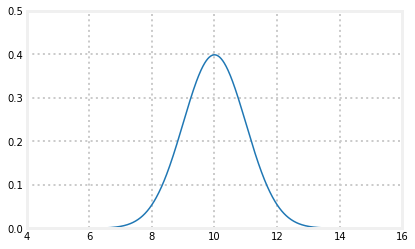

In [44]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., xlim=(4, 16), ylim=(0, .5));

## Tracking with Gaussian Probabilities

The discrete Bayes filter used a histogram of probabilities to track the pidgion. Each bin in the histogram represents a position, and the value is the probability of being in that position.

Tracking was performed with a cycle of predictions and updates. 

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

Recall that $\bar{\mathbf x}$ is the *prior*, $\mathcal L$ is the *likelihood* of a measurement given the prior $\bar{\mathbf x}$, $f_{\mathbf x}(\bullet)$ is the *process model*, and $\ast$ denotes *convolution*. $\mathbf x$ is bold to denote that it is a histogram of numbers, or a vector.

Can we replace $\mathbf x$, the histogram, with a Gaussian $\mathcal N(x, \sigma^2)$? Absolutely! We've learned how to express belief as a Gaussian. A Gaussian, which is a single number pair $\mathcal N(\mu, \sigma^2),$ can replace an entire histogram of probabilities:

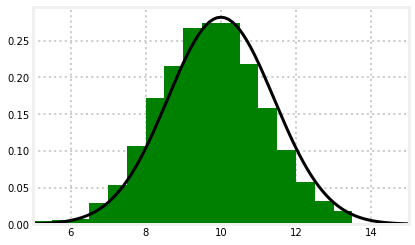

In [45]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

I hope you see the power of this. We can replace hundreds to thousands of numbers with a single pair of numbers: $x = \mathcal N(\mu, \sigma^2)$. 

So we are now replacing histograms with Gaussians:

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

## Predictions with Gaussians

We use Newton's equation of motion to compute current position based on the current velocity and previous position:

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

If the pidgion is at 10 m, his velocity is 15 m/s, and the epoch is 2 seconds long, we have

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

We are uncertain about his current position and velocity, so this will not do. We need to express the uncertainty with a Gaussian.

Position is easy. We define $x$ as a Gaussian. If we think the dog is at 10 m, and the standard deviation of our uncertainty is 0.2 m, we get $x=\mathcal N(10, 0.2^2)$.

What about our uncertainty in his movement? 

We define $f_x$ as a Gaussian. If the dog's velocity is 15 m/s, the epoch is 1 second, and the standard deviation of our uncertainty is 0.7 m/s, we get $f_x = \mathcal N (15, 0.7^2)$.

The equation for the prior is 

$$\bar x = x + f_x$$

What is the sum of two Gaussians?

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

This is fantastic news; the sum of two Gaussians is another Gaussian! 


Think of the physical representation of this abstract equation. We have 

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$

If we add these we get:

$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$


It makes sense that the predicted position is the previous position plus the movement. What about the variance? It is harder to form an intuition about this. However, recall that with the `predict()` function for the discrete Bayes filter we always lost information.

Here is the implementation of the predict function, where `pos` and `movement` are Gaussian tuples in the form ($\mu$, $\sigma^2$):

In [46]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

Let's test it. What is the prior if the intitial position is the Gaussian $\mathcal N(10, 0.2^2)$ and the movement is the Gaussian $\mathcal N (15, 0.7^2)$?

In [47]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

Gaussian(mean=25.0, var=0.5299999999999999)

## Updates with Gaussians

The discrete Bayes filter encodes our belief about the position of our pidgion in a histogram of probabilities. The distribution is discrete and multimodal. It can express strong belief that the pidgion is in two positions at once, and the positions are discrete.

We are proposing that we replace the histogram with a Gaussian. The discrete Bayes filter used this code to compute the posterior:


```python
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

which is an implementation of the equation:

$$x = \| \mathcal L\bar x \|$$

We've just shown that we can represent the prior with a Gaussian. What about the likelihood? 

The likelihood is the probability of the measurement given the current state. We've learned how to represent measurements as Gaussians. For example, maybe our sensor states that the pidgion is at 23 m, with a standard deviation of 0.4 meters. Our measurement, expressed as a likelihood, is $z = \mathcal N (23, 0.16)$.

Both the likelihood and prior are modeled with Gaussians. Can we multiply Gaussians? Is the product of two Gaussians another Gaussian?

Yes to the former, and almost to the latter! The product of two Gaussians is proportional to another Gausian. 

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

We can immediately infer several things. If we normalize the result, the product is another Gaussian. If one Gaussian is the likelihood, and the second is the prior, then the mean is a scaled sum of the prior and the measurement. The variance is a combination of the variances of the prior and measurement. Finally, the variances are completely unaffected by the values of the mean!


We put this in Bayesian terms like so:

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&=\mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

If we implemented that in a function `gaussian_multiply()` we could implement our filter's update step as:

In [48]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

Gaussian(mean=10.799999999999999, var=0.008000000000000002)

### Understanding Gaussian Multiplication



Let's plot the pdf of $\mathcal{N}(10,\, 1) \times \mathcal{N}(10,\, 1)$. Can you determine its shape without looking at the result? What should the new mean be? Will the curve be wider, narrower, or the same as $\mathcal{N}(10,\, 1)$?

Gaussian(mean=10.0, var=0.5)


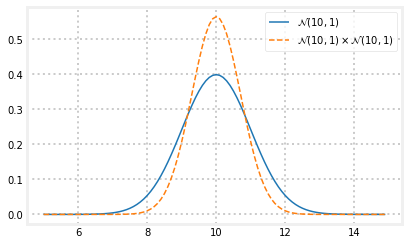

In [49]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

Now let's plot the pdf of $\mathcal{N}(10.2,\, 1) \times \mathcal{N}(9.7,\, 1)$. What do you think the result will be? Think about it, and then look at the graph.

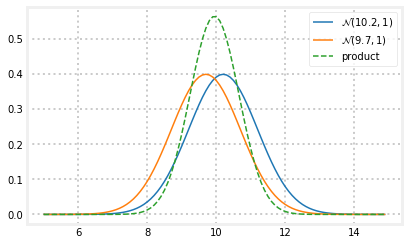

In [50]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

In the update step of the Kalman filter we are not combining two measurements, but one measurement and the prior, our estimate before incorporating the measurement. We went through this logic for the g-h filter. It doesn't matter if we are incorporating information from two measurements, or a measurement and a prediction, the math is the same. 


Let's look at that. I'll create a fairly inaccurate prior of $\mathcal N(8.5, 1.5)$ and a more accurate measurement of $\mathcal N(10.2, 0.5).$ By "accurate" I mean the sensor variance is smaller than the prior's variance, not that I somehow know that the pidgion is closer to 10.2 than 8.5. 

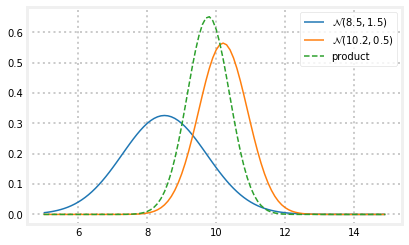

In [51]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

Next I'll plot the reverse relationship: an accurate prior of $\mathcal N(8.5, 0.5)$ and a inaccurate measurement of $\mathcal N(10.2, 1.5)$.

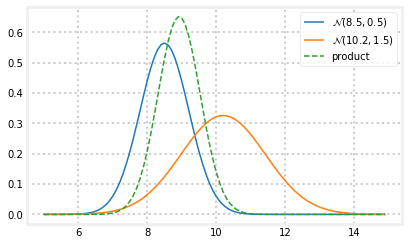

In [52]:
prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

The result is a Gaussian that is taller than either input. This makes sense - we have incorporated information, so our variance should have been reduced. And notice how the result is far closer to the the input with the smaller variance. We have more confidence in that value, so it makes sense to weight it more heavily.

In [53]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

Let's get back to concrete terms and implement a Kalman filter. We've implemented the `update()` and `predict()` functions. We just need to write some boilerplate code to simulate a pidgion and create the measurements. I've put a `PidgionSimulation` class in `kf_internal` to avoid getting distracted with that task. 

In [54]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import PidgionSimulation as PS

np.random.seed(13)

process_var = 1. # variance in the pidgion's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # pidgion's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate pidgion and get measurements
pidgion = PS(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [pidgion.move_and_sense() for _ in range(10)]

And here is the Kalman filter.

In [55]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

xs, predictions = [], []

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
    predictions.append(prior.mean)
    xs.append(x.mean)
    kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(pidgion.x))

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


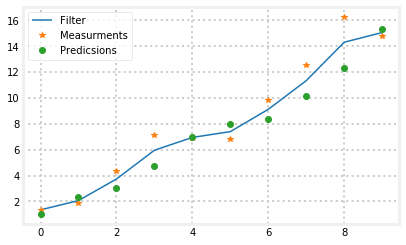

In [56]:
plt.plot(xs,label='Filter')
plt.plot(zs,'*',label='Measurments')
plt.plot(predictions,'o',label='Predicsions')
plt.legend()

If we didn't use the `predict` and `update` functions the code might be:

```python
for z in zs:
    # predict
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var

    # update
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
```    

Just 5 lines of very simple math implements the entire filter!

Now let's look at the filter's performance with more data. The variance is plotted as a lightly shaded yellow area between dotted lines. I've increased the size of the process and sensor variance so they are easier to see on the chart - for a real Kalman filter of course you will not be randomly changing these values.

In [57]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25
# simulate pidgion and get measurements
pidgion = PS(x0=x.mean, velocity=process_model.mean, measurement_var=sensor_var, process_var=process_model.var)

# create list of measurements
zs = [pidgion.move_and_sense() for _ in range(N)]
xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

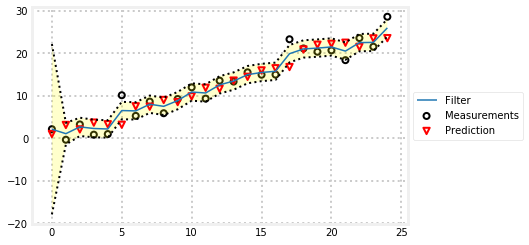

In [58]:
book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()

Here we can see that the variance converges to 2.1623 in 9 steps. This means that we have become very confident in our position estimate. It is equal to $\sigma=1.47$ meters. Contrast this to the sensor's $\sigma=2.12$ meters. The first few measurements are unsure due to our uncertainty of the initial position, but the filter quickly converges to an estimate with lower variance than the sensor!

## Kalman Gain


We see that the filter works. Now let's go back to the math to understand what is happening. The posterior $x$ is computed as the likelihood times the prior ($\mathcal L \bar x$), where both are Gaussians.


Therefore the mean of the posterior is given by:

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$

I use the subscript $z$ to denote the measurement. We can rewrite this as:

$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

In this form it is easy to see that we are scaling the measurement and the prior by weights: 

$$\mu = W_1 \mu_z + W_2 \bar\mu$$

The weights sum to one because the denominator is a normalization term. We introduce a new term, $K=W_1$, giving us:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

where

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

$K$ is the *Kalman gain*. It's the crux of the Kalman filter. It is a scaling term that chooses a value partway between $\mu_z$ and $\bar\mu$.


Let's work a few examples. If the measurement is nine times more accurate than the prior, then $\bar\sigma^2 = 9\sigma_z^2$, and

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$

Hence $K = \frac 9 {10}$, and to form the posterior we take nine tenths of the measurement and one tenth of the prior. 

If the measurement and prior are equally accurate, then $\bar\sigma^2 = \sigma_z^2$ and

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

which is the average of the two means. It makes intuitive sense to take the average of two equally accurate values.

We can also express the variance in terms of the Kalman gain:

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$

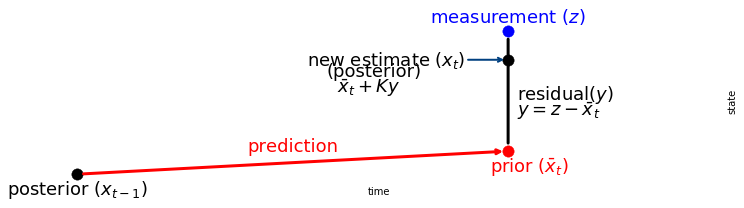

In [59]:
book_plots.show_residual_chart()

The Kalman gain $K$ is a scale factor that chooses a value along the residual. This leads to an alternative but equivalent implementation for `update()` and `predict()`:

In [60]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

Where do the names `z`, `P`, `Q`, and `R` come from? 

In the literature $R$ is nearly universally used for the measurement noise, $Q$ for the process noise and $P$ for the variance of the state. Using $z$ for the measurement is common, albeit not universal. Almost every book and paper you read will use these variable names. Get used to them.


## Full Description of the Algorithm


**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement

The equations for the univariate Kalman filter are:

<u>Predict</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

## Multivariate Normal Distributions

We've been using Gaussians for a scalar random variable, expressed as $\mathcal{N}(\mu, \sigma^2)$. A more formal term for this is *univariate normal*, where univariate means 'one variable'. The probability distribution of the Gaussian is known as the *univariate normal distribution*.

What might a multivariate normal distribution be?

**Multivariate means multiple variables.**

Our goal is to be able to represent a normal distribution with multiple dimensions.

It might be the *x* and *y* coordinates of a robot, it might be the position and velocity of a dog on the x-axis, or milk production and feed rate at a dairy. It doesn't really matter.

We can see that for $N$ dimensions, we need $N$ means, which we will arrange in a column matrix (vector) like so:

$$
\mu = \begin{bmatrix}\mu_1\\\mu_2\\ \vdots \\\mu_n\end{bmatrix}
$$

Let's say we believe that $x = 2$ and $y = 17$. We would have

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

The next step is representing our variances. At first blush we might think we would also need N variances for N dimensions. We might want to say the variance for x is 10 and the variance for y is 4, like so. 

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

This is incomplete because it does not consider the more general case.

Immagine that we measure the heigths and weigths of this class.

If all students are the same height/weigths, then the variance is 0, and if their heights/weigths are wildly different, then the variance will be large. 

Is there a relationship between height and weight?

In general, a taller person weighs more than a shorter person.  

Height and weight are **correlated**. We want a way to express not only what we think the variance is in the height and the weight, but also the degree to which they are correlated. In other words, we want to know how weight varies compared to the heights. We call that the **covariance**. 

**Covariance** describes how much two variables vary together. Covariance is short for **correlated variances**. In other words, **variance** is a measure for how a population vary amongst themselves, and **covariance** is a measure for how much two variables change in relation to each other.

For example, as height increases weight also generally increases. These variables are **correlated**. They are **positively correlated** because as one variable gets larger so does the other. As the outdoor temperature decreases home heating bills increase. These are **inversely correlated** or **negatively correlated** because as one variable gets larger the other variable lowers. The price of tea and the number of wing wags the pidgion makes have no relation to each other, and we say they are **uncorrelated** or **independent** - each can change independent of the other.

**Correlation allows prediction.** 

If you are significantly taller than me I can predict that you also weigh more than me. As winter comes I predict that I will be spending more to heat my house. If the pidgions wags his wings more I don't conclude that tea prices will be changing.

The equation for the covariance between $X$ and $Y$ is

$$ COV(X, Y) = \sigma_{xy} = \mathbb E\big[(X-\mu_x)(Y-\mu_y)\big]$$

We use a *covariance matrix* to denote covariances of a multivariate normal distribution, and it looks like this:
$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

A covariance of 0 indicates no correlation. If the variance for $x$ is 10, the variance for $y$ is 4, and there is no linear correlation between $x$ and $y$, then we would write

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

If there was a small amount of positive correlation between $x$ and $y$ we might have

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

where 1.2 is the covariance between $x$ and $y$. I say the correlation is "small" because the covariance of 1.2 is small relative to the variances of 10.

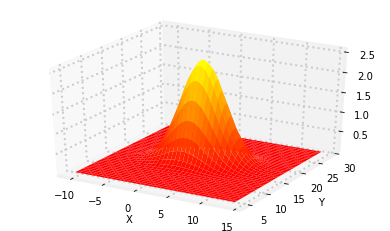

In [61]:
import kf_book.mkf_internal as mkf_internal

mean = [2., 17.]
cov = [[10., 1.2], 
       [1.2, 4.]]

mkf_internal.plot_3d_covariance(mean, cov)

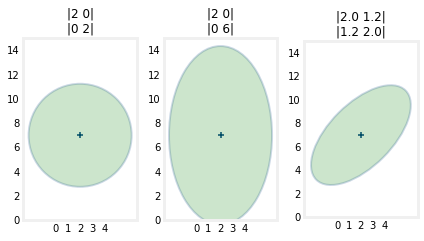

In [62]:
mkf_internal.plot_3_covariances()

These plots show the shape of the slice for 3 standard deviations.

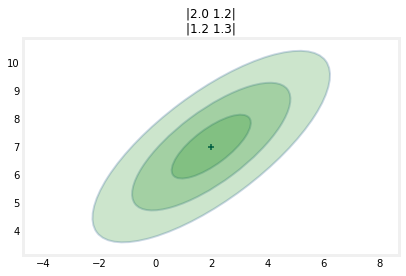

In [63]:
from filterpy.stats import plot_covariance_ellipse
import matplotlib.pyplot as plt

P = [[2, 1.2], [1.2, 1.3]]
plot_covariance_ellipse((2, 7), P, fc='g', alpha=0.2, std=[1, 2, 3],title='|2.0 1.2|\n|1.2 1.3|')
plt.gca().grid(b=False);

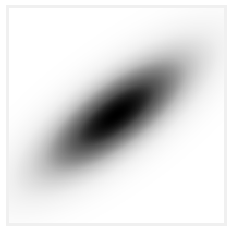

In [64]:
from kf_book.nonlinear_plots import plot_cov_ellipse_colormap
plot_cov_ellipse_colormap(cov=[[2, 1.2], [1.2, 1.3]]);

## Using Correlations to Improve Estimates

Suppose we believe our pidgion is at position (5, 10) with some given covariance. If the standard deviation in x and y is each 2 meters, but they are strongly correlated, the covariance contour would look something like this.

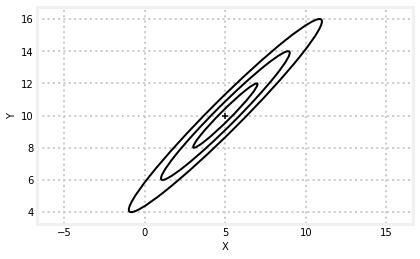

In [65]:
P = [[4, 3.9], [3.9, 4]]

plot_covariance_ellipse((5, 10), P, ec='k', std=[1, 2, 3])
plt.xlabel('X')
plt.ylabel('Y');

Now suppose I were to tell you that we know that $x=7.5$. What can we infer about the value for $y$?

The position is extremely likely to lie within the 3$\sigma$ covariance ellipse. We can infer the position in *y* based on the covariance matrix because there is a correlation between *x* and *y*. 

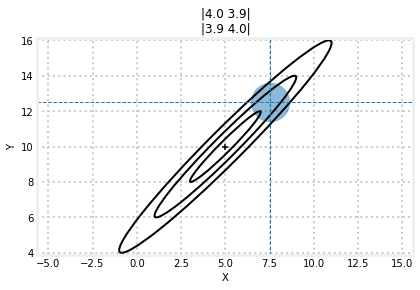

In [66]:
mkf_internal.plot_correlation_covariance()

Suppose that we are tracking an aircraft with two radar systems. Radar provides the range and bearing to a target. We start out being uncertain about the position of the aircraft, so the covariance, which is our uncertainty about the position. In the language of Bayesian statistics this is our **prior**. 

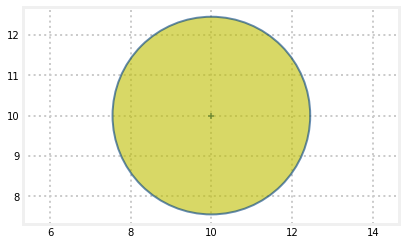

In [67]:
P0 = [[6, 0], [0, 6]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)

Now suppose that there is a radar to the lower left of the aircraft. Further suppose that the radar's bearing (aka direction or angle from the 0°) measurement is accurate, but the range measurement is inaccurate. The covariance for the error in the measurement might look like this (plotted in green on top of the yellow prior):

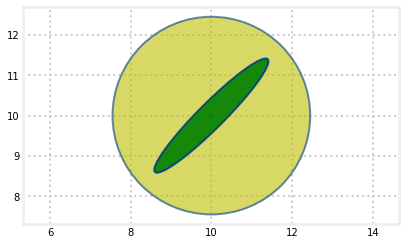

In [68]:
P1 = [[2, 1.9], [1.9, 2]]
plot_covariance_ellipse((10, 10), P0, fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P1, fc='g', alpha=0.9)

We want to find the **posterior** - the mean and covariance that results from incorporating the **evidence** into the **prior**. As in every other chapter we combine evidence by multiplying them together. 

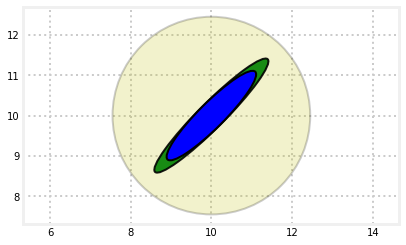

In [69]:
from filterpy.stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]
plot_covariance_ellipse((10, 10), P0, ec='k', fc='y', alpha=0.2)
plot_covariance_ellipse((10, 10), P1, ec='k', fc='g', alpha=0.9)
plot_covariance_ellipse((10, 10), P2, ec='k', fc='b')

The plot shows the original estimate (**prior**) in a very transparent yellow, the radar reading in green (**evidence**), and the finale estimate (**posterior**) in blue.

Now let's say we get a **measurement** (evidence) from a second radar, this one to the lower right. The **posterior** from the last step becomes our new **prior**, which I plot in yellow. 

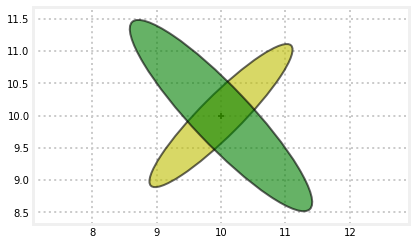

In [70]:
P3 = [[2, -1.9], [-1.9, 2.2]]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)

We can incorporate this information by multiplying the Gaussians:

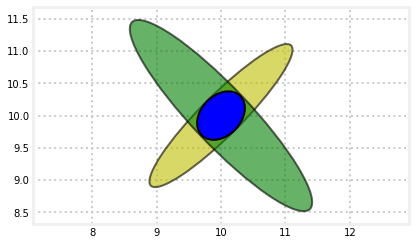

In [71]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]
plot_covariance_ellipse((10, 10), P2, ec='k', fc='y', alpha=0.6)
plot_covariance_ellipse((10, 10), P3, ec='k', fc='g', alpha=0.6)
plot_covariance_ellipse((10, 10), P4, ec='k', fc='b')

## Hidden Variables

You can already see why a multivariate Kalman filter can perform better than a univariate one. Correlations between variables can significantly improve our estimates.

Let's say we are tracking an aircraft and we get the following data for the $x$ and $y$ coordinates at time $t$=1, 2, and 3 seconds. What does your intuition tell you the value of $x$ will be at time $t$=4 seconds?

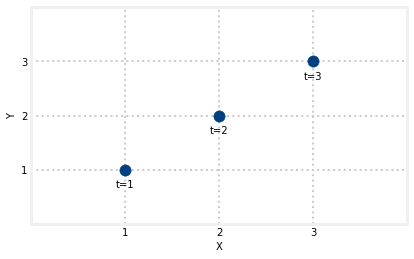

In [72]:
mkf_internal.show_position_chart()

It appears that the aircraft is flying in a straight line and we know that aircraft cannot turn on a dime. The most reasonable guess is that at $t$=4 the aircraft is at (4,4). I will depict that with a green arrow.

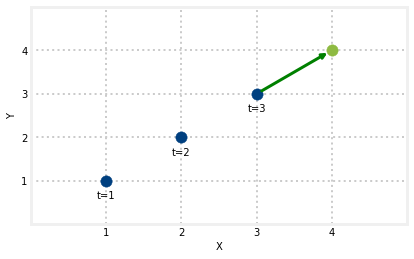

In [73]:
mkf_internal.show_position_prediction_chart()

You made this inference because you *inferred* a constant velocity for the airplane. The reasonable
assumption is that the aircraft is moving one unit each in *x* and *y* per time step.

Immagine now we track the pidgion in the corridor. 

At time 1 we might be fairly certain about the position (x=0) but have no idea about the velocity. We can plot that with a covariance matrix like this. The narrow width expresses our relative certainty about position, and the tall height expresses our lack of knowledge about velocity.

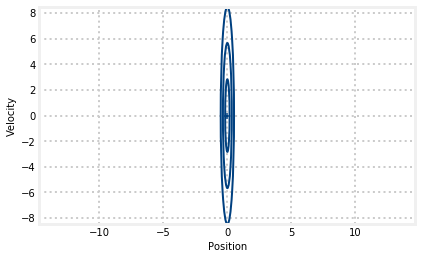

In [74]:
mkf_internal.show_x_error_chart(1)

Now after one second we get a position update of x=5.

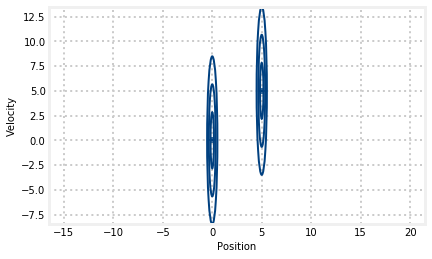

In [75]:
mkf_internal.show_x_error_chart(2)

This implies that our velocity is roughly 5 m/s. But of course position and velocity are correlated. If the velocity is 5 m/s the position would be 5, but if the velocity was 10 m/s the position would be 10. So let's draw a covariance matrix in red showing the relationship between the position and velocity.

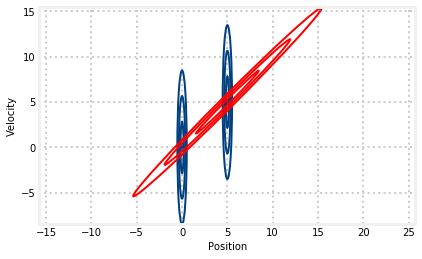

In [76]:
mkf_internal.show_x_error_chart(3)

We have no easy way to say where the object really is because we are so uncertain about the velocity. Hence the ellipse stretches very far in the x-axis. Our uncertainty in velocity of course means it is also very spread in the y-axis. But as I said in the last paragraph, position is correlated to velocity. If the velocity is 5 m/s the next position would be 5, and if the velocity is 10 the next position would be 10. They are very correlated, so the ellipse must be very narrow. 

This superposition of the two covariances is where the magic happens. The only reasonable estimate at time t=1 (where position=5) is roughly the intersection between the two covariance matrices! More exactly, we can use the math from the last section and multiply the two covariances together. From a Bayesian point of view we multiply the prior with the probability of the evidence (the *likelihood*) to get the posterior. If we multiply the position covariance with the velocity covariance using the Bayesian equations we get this result:

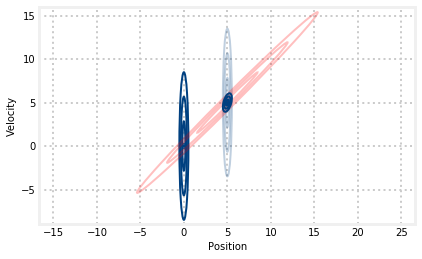

In [77]:
mkf_internal.show_x_error_chart(4)

The new covariance (the posterior) lies at the intersection of the position covariance and the velocity covariance. It is slightly tilted, showing that there is some correlation between the position and velocity. 

The sensor is only detecting the position of the pidgion. This is called an **observed variable**. Based on the position estimates we can compute velocity. We call the velocity a **hidden variable**. 

Hidden means what it sounds like - there is no sensor that is measuring velocity, thus its value is hidden from us. We are able to use the **correlation** between position and velocity to **infer its value** very accurately.

We are now ready to study and implement the full, **multivariate form of the Kalman filter.** 

We learned how multivariate Gaussians express the correlation between multiple random variables, such as the position and velocity of an aircraft. We also learned how correlation between variables drastically improves the posterior. If we only roughly know position and velocity, but they are correlated, then our new estimate can be very accurate.

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use process model to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement

The univariate Kalman filter represented the state with a univariate Gaussian. Naturally the multivariate Kalman filter will use a multivariate Gaussian for the state. We learned in the last chapter that multivariate Gaussians use a vector for the mean and a matrix for the covariances. That means that the Kalman filter needs to use linear algebra to perform the estimations.

<u>**Predict**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

Without worrying about the specifics of the linear algebra, we can see that:

$\mathbf x,\, \mathbf P$ are the state mean and covariance. They correspond to $x$ and $\sigma^2$.

$\mathbf F$ is the *state transition function*. When multiplied by $\bf x$ it computes the prior. 

$\mathbf Q$ is the process covariance. It corresponds to $\sigma^2_{f_x}$.

$\mathbf B$ and $\mathbf u$ are new to us. They let us model control inputs to the system.

<u>**Update**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

$\mathbf H$ is the measurement function. We haven't seen this yet in this book and I'll explain it later. If you mentally remove $\mathbf H$ from the equations, you should be able to see these equations are similar as well.

$\mathbf z,\, \mathbf R$ are the measurement mean and noise covariance. They correspond to $z$ and $\sigma_z^2$ in the univariate filter (I've substituted $\mu$ with $x$ for the univariate equations to make the notation as similar as possible).

$\mathbf y$ and $\mathbf K$ are the residual and Kalman gain.

## Tracking the Pidgion

Let's go back to our tried and true problem of tracking the pidgion. This time we will include the fundamental insight of the previous chapter and use *hidden variables* to improve our estimates. I could start with the math, but instead let's implement a filter, learning as we go. 

We start by writing a simulation for the dog. The simulation will run for `count` steps, moving the dog forward approximately 1 meter for each step. At each step the velocity will vary according to the process variance `process_var`. After updating the position we compute a measurement with an assumed sensor variance of `z_var`.

In [78]:
import math
import numpy as np
from numpy.random import randn

def compute_pidgion_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## Predict Step

For the prediction we need to design the state and covariance, the process model and the process noise, and optionally the control input. We'll take them in order.

### Design State Variable

We previously tracked the pidgion in one dimension by using a Gaussian. The mean $(\mu)$ represented the most likely position, and the variance ($\sigma^2$) represented the probability distribution of the position. The position is the *state* of the system, and we call $\mu$ the *state variable*. 

In this problem we will be tracking both the position and velocity of the dog. This requires us to use a multivariate Gaussian represented with the state vector $\mathbf x$ and its corresponding covariance matrix $\mathbf P$. 

The Kalman filter is implemented using linear algebra. We use an $n\times 1$ matrix (called a *vector*) to store  $n$ state variables. For the pidgion tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot x$, for velocity. I use Newton's dot notation for derivatives; $\dot x$ represents the first derivative of x with respect to t: $\dot x = \frac{dx}{dt}$. Kalman filter equations use $\mathbf x$ for the state, so we define $\mathbf x$ as:

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

### Design State Covariance

The other half of the state Gaussian is the covariance matrix $\mathbf P$. In the univariate Kalman filter we specified an initial value for $\sigma^2$, and then the filter took care of updating its value as measurements were added to the filter. The same thing happens in the multidimensional Kalman filter. We specify an initial value for $\mathbf P$ and the filter updates it during each epoch.

We need to set the variances to reasonable values. For example, we may choose $\sigma_\mathtt{pos}^2=500 m^2$ if we are quite uncertain about the initial position. We migth know that top speed for a pidgion is around 21 m/s, so in the absence of any other information about the velocity we can set $3\sigma_\mathtt{vel}=21$, or $\sigma_\mathtt{vel}^2=7^2=49$. 

In the last chapter we showed that the position and velocities are correlated. But how correlated are they for a dog? I have no idea. As we will see the filter computes this for us, so I initialize the covariances to zero. Of course, if you know the covariances you should use them. 


Recall that the diagonals of the covariance matrix contains the variance of each variable, and the off-diagonal elements contains the covariances. Thus we have:

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

###  Design the Process Model

We use the process model to perform the *innovation*, because the equations tell us what the next state will be given the current state. Kalman filters implement this using this linear equation, where $\mathbf{\bar x}$ is the *prior*, or predicted state:

$$\mathbf{\bar x} = \mathbf{Fx}$$

which we can make explicit as

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

We already know the equation for the position innovation:

$$\bar x = x + \dot x \Delta t$$

What is our equation for velocity? We have no predictive model for how our pidgion's velocity will change over time. In this case we assume that it remains constant between innovations. 

$$\bar{\dot x} = \dot x$$

This gives us the process model for our system 

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

We can rewrite this in matrix form as

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

$\mathbf F$ is called the *state transition function* or the *state transition matrix*.

Let's test this! FilterPy has a `predict` method that performs the prediction by computing $\mathbf{\bar x} = \mathbf{Fx}$. Let's call it and see what happens. We've set the position to 10.0 and the velocity to  4.5 meter/sec. We've defined `dt = 0.1`, which means the time step is 0.1 seconds, so we expect the new position to be 10.45 meters after the innovation. The velocity should be unchanged.

In [79]:
from filterpy.kalman import predict

x = np.array([10.0, 4.5])
P = np.diag([500, 49])
F = np.array([[1, dt], [0, 1]])

# Q is the process noise
x, P = predict(x=x, P=P, F=F, Q=0)
print('x =', x)

x = [14.5  4.5]


This worked. If we call `predict()` several times in a row the value will be updated each time. 

In [80]:
for _ in range(4):
    x, P = predict(x=x, P=P, F=F, Q=0)
    print('x =', x)

x = [19.   4.5]
x = [23.5  4.5]
x = [28.   4.5]
x = [32.5  4.5]


This is the value of  𝐏  after five innovations (predictions), which we denote  𝐏¯  in the Kalman filter equations.

In [81]:
print(P)

[[1725.  245.]
 [ 245.   49.]]


Inspecting the diagonals shows us that the position variance got larger. We've performed five prediction steps with no measurements, and our uncertainty grew. The off-diagonal elements became non-zero - the Kalman filter detected a correlation between position and velocity! The variance of the velocity did not change.


## Design Process Noise

A quick review on *process noise*. A car is driving along the road with the cruise control on; it should travel at a constant speed. We model this with $\bar x_k=\dot x_k\Delta t + x_{k-1}$. However, it is affected by a number of unknown factors. The cruise control cannot perfectly maintain a constant velocity. Winds affect the car, as do hills and potholes. Passengers roll down windows, changing the drag profile of the car. 


We can model this system with the differential equation

$$\dot{\mathbf x} = f(\mathbf x) + w$$

where $f(\mathbf x)$ models the state transition and $w$ is *white process noise*.

FilterPy provides functions which compute $\mathbf Q$ for the kinematic problems of this chapter. `Q_discrete_white_noise` takes 3 parameters. `dim`, which specifies the dimension of the matrix, `dt`, which is the time step in seconds, and `var`, the variance in the noise. Briefly, it discretizes the noise over the given time period under assumptions that we will discuss later. This code computes $\mathbf Q$ for white noise with a variance of 2.35 and a time step of 1 seconds:

In [82]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


## Design the Control Function

The Kalman filter does not just filter data, it allows us to incorporate the control inputs of systems like robots and airplanes. Suppose we are controlling a robot. At each time step we would send steering and velocity signals to the robot based on its current position vs desired position. Kalman filter equations incorporate that knowledge into the filter equations, creating a predicted position based both on current velocity and control inputs to the drive motors. Remember, we *never* throw information away.


For a linear system the effect of control inputs can be described as a set of linear equations, which we can express with linear algebra as

$$\Delta\mathbf x = \mathbf{Bu}$$

Therefore the complete Kalman filter equation for the prior mean is

$$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$$

and this is the equation that is computed when you call `KalmanFilter.predict()`.

In [83]:
B = 0.  # the pidgion doesn't listen to us!
u = 0
x, P = predict(x, P, F, Q, B, u)
print('x =', x)
print('P =', P)

x = [37.   4.5]
P = [[2264.5875  295.175 ]
 [ 295.175    51.35  ]]



## Prediction: Summary

Your job as a designer is to specify the matrices for

* $\mathbf x$, $\mathbf P$: the state and covariance
* $\mathbf F$,  $\mathbf Q$: the process model and noise covariance
* $\mathbf{B,u}$: Optionally, the control input and function

## Update Step

Now we can implement the update step of the filter. You only have to supply two more matrices, and they are easy to understand. 

### Design the Measurement Function

The Kalman filter computes the update step in what we call *measurement space*. We tracked the pidgion's position using a sensor that reported his position. Computing the *residual* was easy - subtract the filter's predicted position from the measurement:

$$ \mathtt{residual} = \mathtt{measured\, \, position} - \mathtt{predicted\, \, position}$$

We need to compute the residual because we scale it by the Kalman gain to get the new estimate.

What would happen if we were trying to track temperature using a thermometer that outputs a voltage corresponding to the temperature reading? The equation for the residual computation would be meaningless; you can't subtract a temperature from a voltage.

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$


We need to convert the temperature into a voltage so we can perform the subtraction. For the thermometer we might write:

```python
CELSIUS_TO_VOLTS = 0.21475
residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```

Both the measurement $\mathbf z$ and state $\mathbf x$ are vectors so we need to use a matrix to perform the conversion. The Kalman filter equation that performs this step is:

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$

where $\mathbf y$ is the residual, $\mathbf{\bar x}$ is the prior, $\mathbf z$ is the measurement, and $\mathbf H$ is the measurement function. So we take the prior, convert it to a measurement by multiplying it with $\mathbf H$, and subtract that from the measurement. This gives us the difference between our prediction and measurement in measurement space!
<img src="./figs/residual_chart_with_h.png">

We need to design $\mathbf H$ so that $\mathbf{H\bar x}$ yields a measurement. For this problem we have a sensor that measures position, so $\mathbf z$ will be a one variable vector:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

The residual equation will have the form

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ has to be a 1x2 matrix for $\mathbf{Hx}$ to be 1x1. Recall that multiplying matrices $m\times n$ by $n\times p$ yields a $m\times p$ matrix.

We will want to multiply the position $x$ by 1 to get the corresponding measurement of the position. We do not need to use velocity to find the corresponding measurement so we multiply  $\dot x$ by 0.

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$


And so, for our Kalman filter we set

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

## Implementing the Kalman Filter

We have all of the code for the filter, but now let's collect it in one place. First we construct a `KalmanFilter` object. We have to specify the number of variables in the state with the `dim_x` parameter, and the number of measurements with `dim_z`. We have two random variables in the state and one measurement, so we write:

```python
from filterpy.kalman import KalmanFilter
pidgion_filter = KalmanFilter(dim_x=2, dim_z=1)
```

This creates an object with default values for all the Kalman filter matrices:

In [84]:
from filterpy.kalman import KalmanFilter
pidgion_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', pidgion_filter.x.T)
print('R = ', pidgion_filter.R)
print('Q = \n', pidgion_filter.Q)

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


Now we initialize the filter's matrices and vectors with values valid for our problem. I've put this in a function to allow you to specify different initial values for `R`, `P`, and `Q` and put it in a helper function.

In [85]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]]) # location and velocity
    kf.F = np.array([[1., dt],
                     [0.,  1.]])  # state transition matrix
    kf.H = np.array([[1., 0]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [86]:
from kf_book.mkf_internal import plot_track

def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate pidgion if no data provided. 
    if zs is None:
        track, zs = compute_pidgion_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, 
                   dt=dt, **kwargs)
    return xs, cov

Let's run it. We have 50 measurements with a noise variance of 10 and a process variance of 0.01.

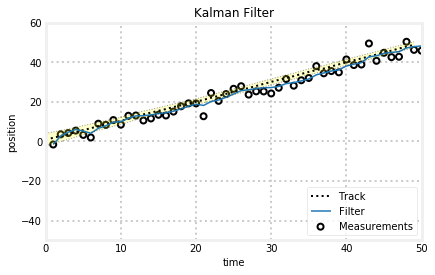

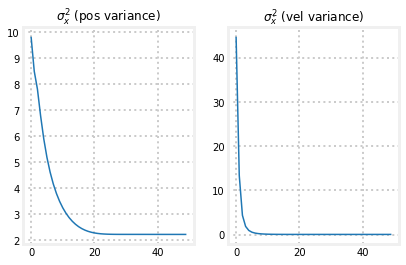

In [87]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

### Prediction Equations

The Kalman filter uses these equations to compute the *prior* - the predicted next state of the system. They compute the prior mean ($\bar{\mathbf x}$)  and covariance ($\bar{\mathbf P}$) of the system.

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf{Fx} + \mathbf{Bu}\\
\mathbf{\bar P} &= \mathbf{FPF}^\mathsf T + \mathbf Q
\end{aligned}$$


### Update Equations

Before I continue, recall that we are trying to do something very simple: choose a new estimate chosen somewhere between a measurement and a prediction, as in this chart:
<img src="./figs/residual_chart.png">

$\underline{\textbf{System Uncertainty}}$

$\textbf{S} = \mathbf{H\bar PH}^\mathsf T + \mathbf R$

To work in measurement space the Kalman filter has to project the covariance matrix into measurement space. The math for this is $\mathbf{H\bar PH}^\mathsf T$, where $\mathbf{\bar P}$ is the *prior* covariance and $\mathbf H$ is the measurement function.

$\underline{\textbf{Kalman Gain}}$

$\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}$

$K$ is the *Kalman gain*, and it is a real number between 0 and 1. Ensure you understand how it selects a mean somewhere between the prediction and measurement. The Kalman gain is a *percentage* or *ratio* - if K is .9 it takes 90% of the measurement and 10% of the prediction. The Kalman gain equation computes a ratio based on how much we trust the prediction vs the measurement.

$\underline{\textbf{Residual}}$

$\mathbf y = \mathbf z - \mathbf{H\bar{x}}$

This is an easy one as we've covered this equation while designing the measurement function $\mathbf H$. Recall that the measurement function converts a state into a measurement. So $\mathbf{Hx}$ converts $\mathbf x$ into an equivalent measurement. Once that is done, we can subtract it from the measurement $\mathbf z$ to get the residual - the difference between the measurement and prediction.

$\underline{\textbf{State Update}}$

$\mathbf x = \mathbf{\bar x} + \mathbf{Ky}$

We select our new state to be along the residual, scaled by the Kalman gain. The scaling is performed by $\mathbf{Ky}$, which both scales the residual and converts it back into state space with the $\mathbf H^\mathsf T$ term which is in $\mathbf K$. This is added to the prior, yielding the equation: $\mathbf x =\mathbf{\bar x} + \mathbf{Ky}$. Let me write out $\mathbf K$ so we can see the entire computation:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} + \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1}\mathbf y \\
&\approx \mathbf{\bar x} + \frac{\mathsf{uncertainty}_\mathsf{prediction}}{\mathsf{uncertainty}_\mathsf{measurement}}\mathbf H^\mathsf T\mathbf y
\end{aligned}$$

Perhaps a better way to *see* the ratio is to rewrite the estimate equation:

$$\begin{aligned}
\mathbf x &= \mathbf{\bar x} + \mathbf{Ky} \\
&= \mathbf{\bar x} +\mathbf K(\mathbf z - \mathbf{H\bar x}) \\
&= (\mathbf I - \mathbf{KH})\mathbf{\bar x} + \mathbf{Kz}
\end{aligned}$$

$\underline{\textbf{Covariance Update}}$

$\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}$

$\mathbf{I}$ is the identity matrix, and is the way we represent $1$ in multiple dimensions. $\mathbf H$ is our measurement function, and is a constant.  We can think of the equation as $\mathbf P = (1-c\mathbf K)\mathbf P$. $\mathbf K$ is our ratio of how much prediction vs measurement we use. If $\mathbf K$ is large then $(1-\mathbf{cK})$ is small, and $\mathbf P$ will be made smaller than it was. If $\mathbf K$ is small, then $(1-\mathbf{cK})$ is large, and $\mathbf P$ will be relatively larger. This means that we adjust the size of our uncertainty by some factor of the Kalman gain.

### An Example not using FilterPy


In [88]:
from numpy import dot
from scipy.linalg import inv
dt = 1.
R_var = 10
Q_var = 0.01
x = np.array([[10.0, 4.5]]).T
P = np.diag([500, 49])
F = np.array([[1, dt],
              [0,  1]])
H = np.array([[1., 0.]])
R = np.array([[R_var]])
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)


count = 50
track, zs = compute_pidgion_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = dot(F, x) #prior
    P = dot(F, P).dot(F.T) + Q #prior covariance
    
    #update
    S = dot(H, P).dot(H.T) + R #system uncertanty
    K = dot(P, H.T).dot(inv(S)) #kalman gain
    y = z - dot(H, x) #residual
    x += dot(K, y) #posterior
    P = P - dot(K, H).dot(P) #posterior covariance
    
    xs.append(x)
    cov.append(P)

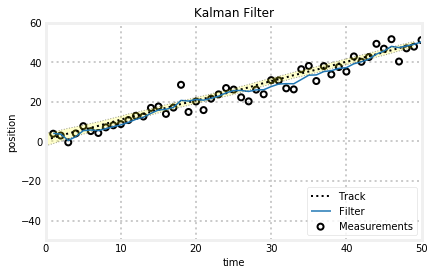

In [89]:
xs, cov = np.array(xs), np.array(cov)
plot_track(xs[:, 0], track, zs, cov, plot_P=False, dt=dt)

## Summary

We have learned the Kalman filter equations. Here they are all together for your review. There was a lot to learn, but I hope that as you went through each you recognized it's kinship with the equations in the univariate filter. In the *Kalman Math* chapter I will show you that if we set the dimension of $\mathbf x$ to one that these equations revert back to the equations for the univariate filter. This is not "like" the univariate filter - it is a multidimensional implementation of it.

$$
\begin{aligned}
\text{Predict Step}\\
\mathbf{\bar x} &= \mathbf{F x} + \mathbf{B u} \\
\mathbf{\bar P} &= \mathbf{FP{F}}^\mathsf T + \mathbf Q \\
\\
\text{Update Step}\\
\textbf{S} &= \mathbf{H\bar PH}^\mathsf T + \mathbf R \\
\mathbf K &= \mathbf{\bar PH}^\mathsf T \mathbf{S}^{-1} \\
\textbf{y} &= \mathbf z - \mathbf{H \bar x} \\
\mathbf x &=\mathbf{\bar x} +\mathbf{K\textbf{y}} \\
\mathbf P &= (\mathbf{I}-\mathbf{KH})\mathbf{\bar P}
\end{aligned}
$$

<img src='figs/kalman_algo.png'>